<a href="https://colab.research.google.com/github/MohanKumar68/Netflix_Shows_Movies_Analysis/blob/main/netflix_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction: Netflix Shows and Movies Analysis**

The objective of this project is to analyze the Netflix dataset which contains information about Movies and TV Shows available on the platform. The dataset includes attributes such as title, type (Movie/TV Show), director, cast, country, release year, duration, rating, and description.


**This project demonstrates :**

**Data Cleaning & Preprocessing** –handling missing values, encoding categorical features, and preparing the dataset for analysis.

**Exploratory Data Analysis (EDA) –** using visualization (Matplotlib/Seaborn) to understand the distribution of content by type, country, genre, and ratings.

**Classification Task** – predicting whether a title is a Movie or a TV Show based on its attributes.

**Regression Task** – predicting the duration of movies (in minutes) using features like release year, cast size, genres, and description length.

**Model Evaluation** – applying different ML models such as Logistic Regression, Random Forest, and Linear Regression, and comparing their performance using accuracy, R² score, RMSE, and confusion matrices.



**The following analysis demonstrates…**

Loading and exploring data

Cleaning and feature engineering

Applying machine learning models

Visualizing and interpreting results

**Initial steps :**

In the initial steps of this project, i began by importing the required libraries and uploading the dataset for analysis. Once loaded, i performed a quick inspection of the data to understand its structure, identified missing values, and detected any inconsistencies. To ensure a clean foundation for further processing, I remove duplicate records and standardize column names such as trimming unnecessary whitespace.

In [ ]:
#uploading the dataset
from google.colab import files
uploaded=files.upload()

Saving netflix_titles.csv to netflix_titles (1).csv


In [ ]:
# 1) Imports required
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
import re
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

In [ ]:
# 2) Loading the data
df = pd.read_csv("netflix_titles.csv")
print("Shape:", df.shape)
df.head()

Shape: (8807, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [ ]:
# 3) Quick info + missing values
print("\nColumns and dtypes:\n", df.dtypes)
print("\nMissing values per column:\n", df.isnull().sum())


Columns and dtypes:
 show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object

Missing values per column:
 show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64


In [ ]:
# 4) Basic cleaning
# Drop exact duplicate rows if any
df.drop_duplicates(inplace=True)

# Standardizing column names
# Triming whitespace
for c in df.columns:
    if df[c].dtype == object:
        df[c] = df[c].astype(str).str.strip()

**5) Parse date_added → datetime and extract year/month**

In this step, I converted the date_added column into a proper datetime format, and extracted useful features such as the year and month when a title was added to the platform. This helps in time-based analysis.

In [ ]:
# 5) Parse date_added -> datetime and extract year/month
def parse_date_added(s):
    try:
        return pd.to_datetime(s)
    except:
        return pd.NaT

df['date_added_parsed'] = df['date_added'].apply(parse_date_added)
df['year_added'] = df['date_added_parsed'].dt.year
df['month_added'] = df['date_added_parsed'].dt.month

**6) Parse duration: convert "90 min" → 90 (minutes); "3 Seasons" → 3 (seasons)**

Here, I standardize the duration column by separating movies (in minutes) and TV shows (in seasons), making it easier to use as a numeric feature for analysis and modeling.

In [ ]:
# 6) Parse duration: convert "90 min" -> 90 (minutes); "3 Seasons" -> 3 (seasons)
def parse_duration(x):
    if pd.isna(x):
        return (np.nan, np.nan)  # (minutes, seasons)
    s = str(x).lower().strip()
    # minutes
    m = re.search(r'(\d+)\s*min', s)
    if m:
        return (int(m.group(1)), np.nan)
    # seasons
    m2 = re.search(r'(\d+)\s*season', s)
    if m2:
        return (np.nan, int(m2.group(1)))
    # fallback try digits
    m3 = re.search(r'(\d+)', s)
    if m3:
        return (int(m3.group(1)), np.nan)
    return (np.nan, np.nan)

dur_parsed = df['duration'].apply(parse_duration)
df['duration_minutes'] = dur_parsed.apply(lambda t: t[0])
df['duration_seasons'] = dur_parsed.apply(lambda t: t[1])

**7) Feature engineering: description length, title length, cast count, director present**

In this block, I created additional features such as the length of the description, title length, number of cast members, and a binary flag for whether a director is listed. These engineered features add more depth to the dataset for predictive modeling.

In [ ]:
# 7) Feature engineering: description length, title length, cast count, director present
df['description_len'] = df['description'].fillna("").apply(len)
df['title_len'] = df['title'].fillna("").apply(len)
df['cast_count'] = df['cast'].replace('nan','').apply(lambda s: 0 if s in ['', 'nan'] else len([x for x in s.split(',') if x.strip()!='']))
df['has_director'] = (~df['director'].isnull() & (df['director'].str.strip()!='')).astype(int)
df['listed_in_count'] = df['listed_in'].fillna("").apply(lambda s: len([x for x in s.split(',') if x.strip()!='']))
df['country_count'] = df['country'].fillna("").apply(lambda s: len([x for x in s.split(',') if x.strip()!='']))

**8) Simplify high-cardinality columns: keep top N countries & top N genres, others → "Other"**

Since columns like country and listed_in (genres) contain too many unique values, I simplified them by retaining only the most frequent categories and grouping the rest as Other. This reduces noise and improves model performance.

In [ ]:
# 8) Simplify high-cardinality columns: keep top N countries & top N genres, others->'Other'
top_countries = df['country'].value_counts().nlargest(10).index.tolist()
df['country_top'] = df['country'].apply(lambda s: s if s in top_countries else 'Other')
# For listed_in (genres) take first genre as a simple approach
df['main_genre'] = df['listed_in'].fillna('Unknown').apply(lambda s: s.split(',')[0].strip())

**9) Quick EDA plots (seaborn)**

Here, I visualized key patterns in the dataset using plots (eg, type distribution, content added per year). These exploratory plots provide insights into the data and highlight trends that guide later modeling steps.

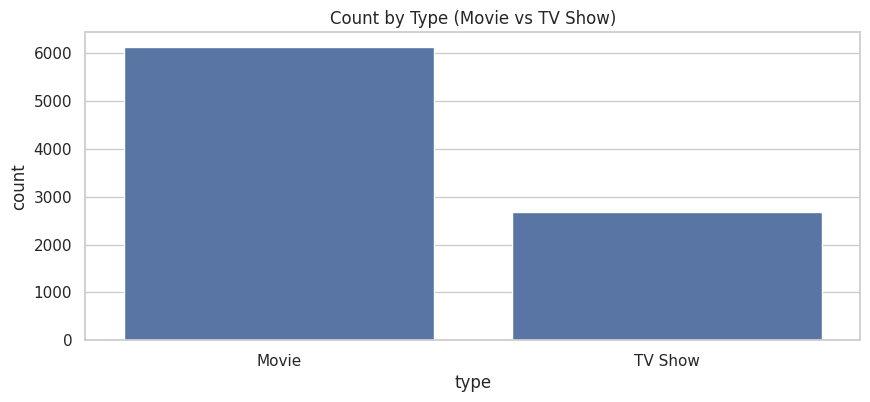

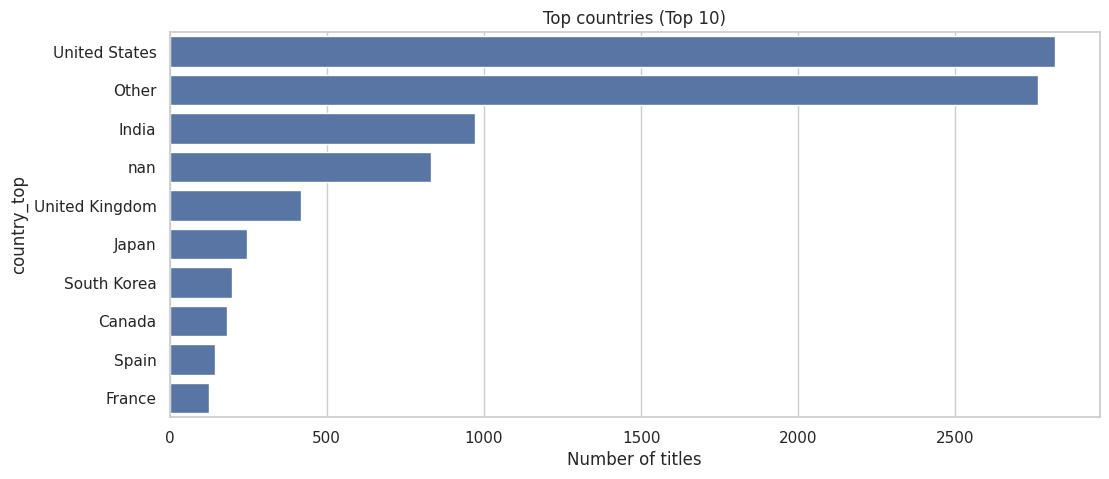

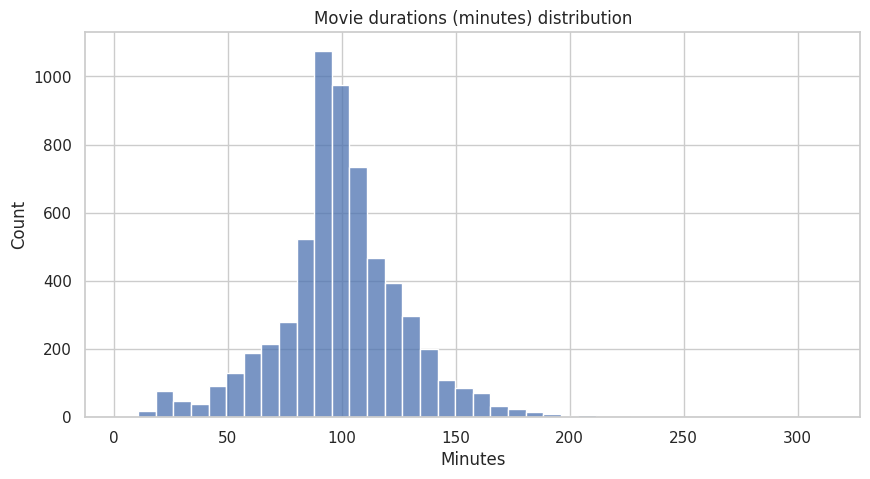

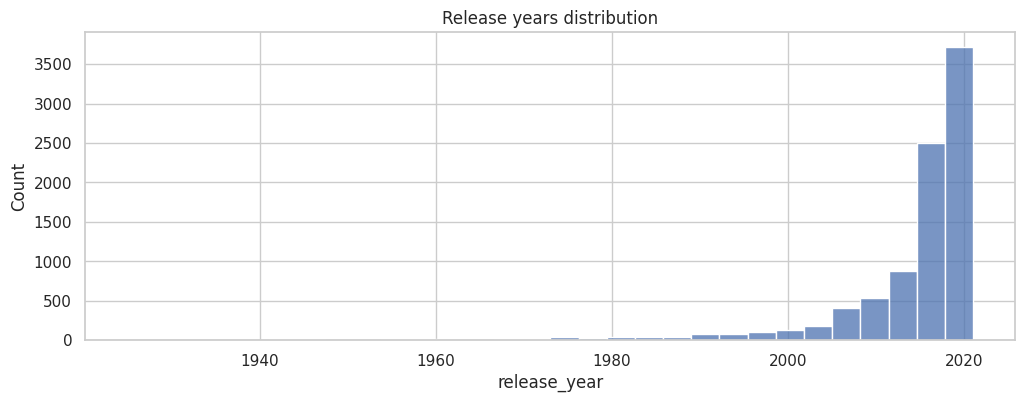

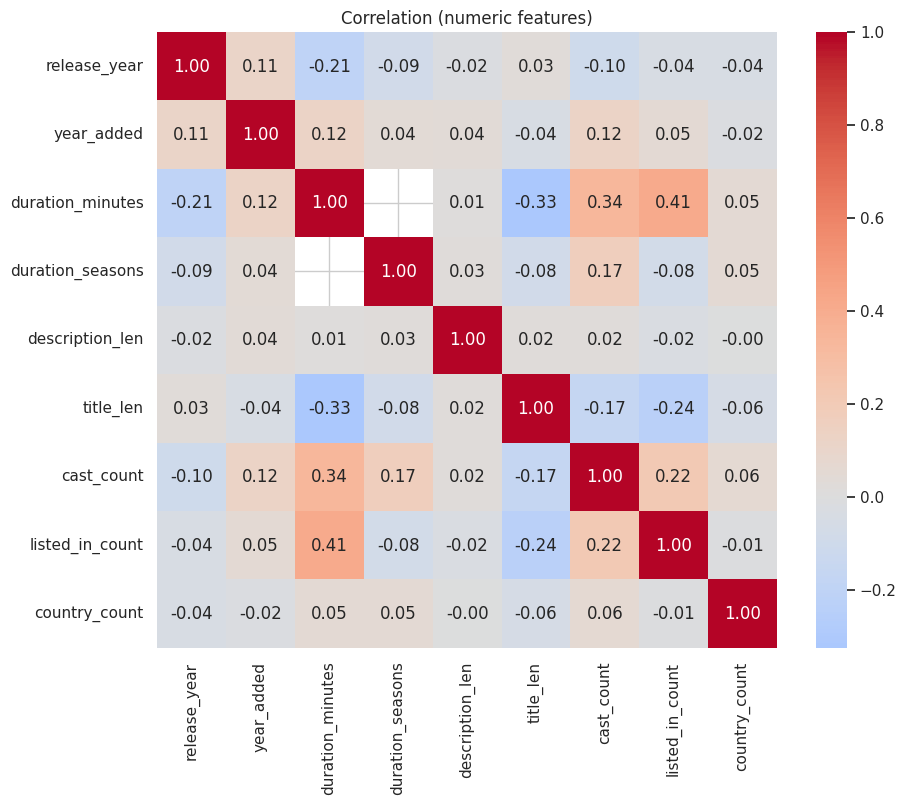

In [ ]:
# 9) Quick EDA plots (seaborn)
plt.figure(figsize=(10,4))
ax = sns.countplot(data=df, x='type', order=df['type'].value_counts().index)
plt.title("Count by Type (Movie vs TV Show)")
plt.show()

plt.figure(figsize=(12,5))
top_c = df['country_top'].value_counts().nlargest(10)
sns.barplot(x=top_c.values, y=top_c.index)
plt.title("Top countries (Top 10)")
plt.xlabel("Number of titles")
plt.show()

# Duration distribution for Movies (minutes)
plt.figure(figsize=(10,5))
sns.histplot(df[df['type']=='Movie']['duration_minutes'].dropna(), bins=40)
plt.title("Movie durations (minutes) distribution")
plt.xlabel("Minutes")
plt.show()

# Releases by year (release_year column)
plt.figure(figsize=(12,4))
sns.histplot(df['release_year'].dropna(), bins=30)
plt.title("Release years distribution")
plt.show()

# Correlation heatmap on numeric features
num_cols = ['release_year','year_added','duration_minutes','duration_seasons',
            'description_len','title_len','cast_count','listed_in_count','country_count']
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation (numeric features)")
plt.show()

**10) Classification Task: Predicting Type (Movie vs TV Show)**

In this section, I attempted to classify Netflix titles as either Movie or TV Show using features such as release year, cast size, and other attributes. I applied preprocessing steps like imputing missing values, scaling numeric features, and one hot encoding categorical ones, followed by a Logistic Regression model.

Logistic Regression Accuracy: 1.0
              precision    recall  f1-score   support

       Movie       1.00      1.00      1.00      1533
     TV Show       1.00      1.00      1.00       669

    accuracy                           1.00      2202
   macro avg       1.00      1.00      1.00      2202
weighted avg       1.00      1.00      1.00      2202



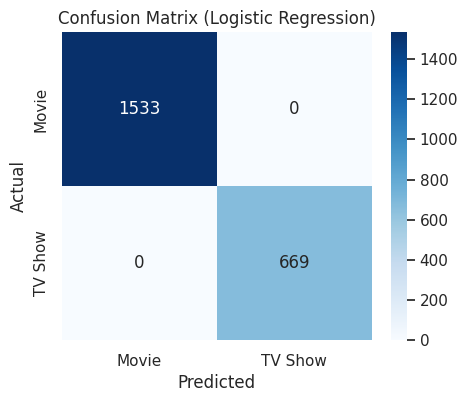

Random Forest Accuracy: 0.9995458673932789
              precision    recall  f1-score   support

       Movie       1.00      1.00      1.00      1533
     TV Show       1.00      1.00      1.00       669

    accuracy                           1.00      2202
   macro avg       1.00      1.00      1.00      2202
weighted avg       1.00      1.00      1.00      2202



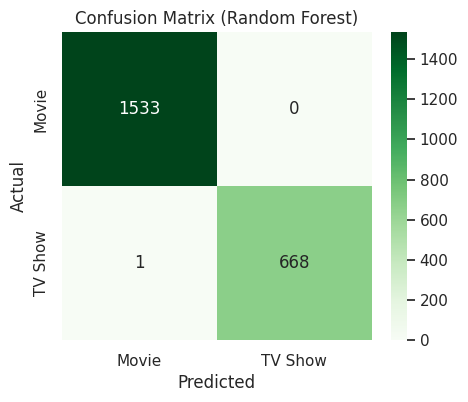

In [ ]:
# 10) Prepare dataset for Classification: Predict 'type' (Movie vs TV Show)

clf_df = df[df['type'].isin(['Movie','TV Show'])].copy()

features = [
    'release_year', 'year_added', 'description_len', 'title_len',
    'cast_count', 'has_director', 'listed_in_count',
    'country_top', 'main_genre', 'rating'
]

clf_df = clf_df[features + ['type']].dropna(subset=['type'])

# Simplify rating
top_ratings = clf_df['rating'].value_counts().nlargest(6).index.tolist()
clf_df['rating_top'] = clf_df['rating'].apply(lambda s: s if s in top_ratings else 'Other')

X_clf = clf_df[
    ['release_year','year_added','description_len','title_len',
     'cast_count','has_director','listed_in_count',
     'country_top','main_genre','rating_top']
].copy()
y_clf = clf_df['type']

# Encode labels
from sklearn.preprocessing import LabelEncoder
le_type = LabelEncoder()
y_clf_enc = le_type.fit_transform(y_clf)

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_clf, y_clf_enc, test_size=0.25, random_state=42, stratify=y_clf_enc
)

# Preprocessor with imputers
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

numeric_features = [
    'release_year','year_added','description_len',
    'title_len','cast_count','has_director','listed_in_count'
]
categorical_features = ['country_top','main_genre','rating_top']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_features)
    ]
)

# Pipelines
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

pipe_lr = Pipeline([('pre', preprocessor), ('clf', LogisticRegression(max_iter=500))])
pipe_rf = Pipeline([('pre', preprocessor), ('clf', RandomForestClassifier(n_estimators=200, random_state=42))])

# Logistic Regression
pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr, target_names=le_type.classes_))

cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le_type.classes_, yticklabels=le_type.classes_, cmap='Blues')
plt.title("Confusion Matrix (Logistic Regression)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Random Forest
pipe_rf.fit(X_train, y_train)
y_pred_rf = pipe_rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=le_type.classes_))

cm2 = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm2, annot=True, fmt='d',
            xticklabels=le_type.classes_, yticklabels=le_type.classes_, cmap='Greens')
plt.title("Confusion Matrix (Random Forest)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()




**Challenges Faced:**

During implementation, we faced issues with missing values in both numeric and categorical columns.
To overcome this I
Added SimpleImputer(strategy='median') for numeric features.
Added SimpleImputer(strategy='most_frequent') for categorical features.
Wrapped these imputers inside Pipelines within a ColumnTransformer to streamline preprocessing

**11) Regression Task: Predicting Movie Duration**

In this section, I focused on predicting the duration of movies (in minutes) using different regression models such as Linear Regression and Random Forest. To ensure valid predictions, only rows with properly recorded duration values were included.


Movie regression dataset size: (6128, 25)

Linear Regression RMSE: 23.935299322802308
Linear Regression R2: 0.20294971743622425


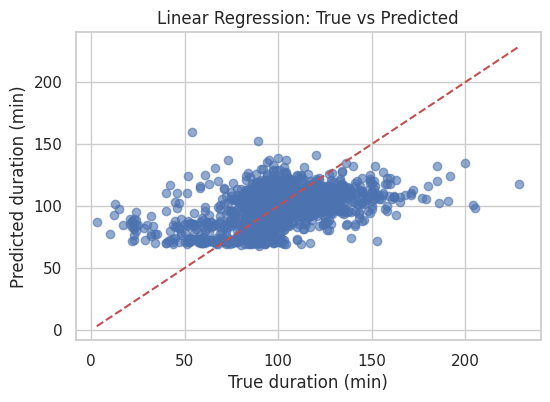


Random Forest RMSE: 24.445275515825383
Random Forest R2: 0.16862326510612802


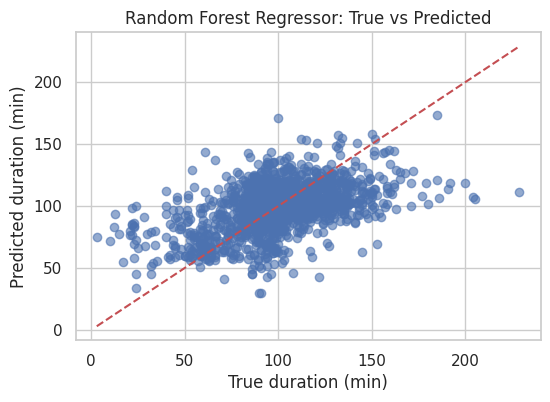

In [ ]:
# 11) Regression task: Predict movie duration (minutes) [only movies with valid minutes]
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Filter only Movies with valid durations
reg_df = df[(df['type']=='Movie') & (df['duration_minutes'].notnull())].copy()
print("\nMovie regression dataset size:", reg_df.shape)

# Features: simple numeric ones
reg_features = ['release_year','year_added','description_len','cast_count','listed_in_count','has_director']
X_reg = reg_df[reg_features]
y_reg = reg_df['duration_minutes']

# Train/test split
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reg, y_reg, test_size=0.25, random_state=42)

# Pipelines
pipe_linreg = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())])
pipe_rfr = Pipeline([('scaler', StandardScaler()), ('rfr', RandomForestRegressor(n_estimators=200, random_state=42))])

# ===== Linear Regression =====
pipe_linreg.fit(Xr_train, yr_train)
yr_pred_lr = pipe_linreg.predict(Xr_test)

rmse_lr = np.sqrt(mean_squared_error(yr_test, yr_pred_lr))
r2_lr = r2_score(yr_test, yr_pred_lr)

print("\nLinear Regression RMSE:", rmse_lr)
print("Linear Regression R2:", r2_lr)

plt.figure(figsize=(6,4))
plt.scatter(yr_test, yr_pred_lr, alpha=0.6)
plt.plot([yr_test.min(), yr_test.max()], [yr_test.min(), yr_test.max()], 'r--')
plt.xlabel("True duration (min)")
plt.ylabel("Predicted duration (min)")
plt.title("Linear Regression: True vs Predicted")
plt.show()

# ===== Random Forest Regressor =====
pipe_rfr.fit(Xr_train, yr_train)
yr_pred_rfr = pipe_rfr.predict(Xr_test)

rmse_rfr = np.sqrt(mean_squared_error(yr_test, yr_pred_rfr))
r2_rfr = r2_score(yr_test, yr_pred_rfr)

print("\nRandom Forest RMSE:", rmse_rfr)
print("Random Forest R2:", r2_rfr)

plt.figure(figsize=(6,4))
plt.scatter(yr_test, yr_pred_rfr, alpha=0.6)
plt.plot([yr_test.min(), yr_test.max()], [yr_test.min(), yr_test.max()], 'r--')
plt.xlabel("True duration (min)")
plt.ylabel("Predicted duration (min)")
plt.title("Random Forest Regressor: True vs Predicted")
plt.show()




**Challenges Faced:**

While implementing this part, I initially encountered an error with the mean_squared_error function due to the squared=False parameter not being supported. This was resolved by switching to np.sqrt(mean_squared_error() to calculate RMSE manually. Additionally, missing imports for regression models were added to make the block fully self contained.

**12) Useful Quick Outputs for the Report**

In this final section, I generated quick summary outputs such as dataset dimensions, column details, and feature distributions. These provide a concise overview of the dataset and help in validating preprocessing steps, ensuring that the report is well supported with essential statistics and insights.

In [ ]:

# 12) Useful quick outputs for your report
print("\nTop 10 directors (counts):\n", df['director'].value_counts().nlargest(10))
print("\nTop 10 genres (listed_in first token):\n", df['main_genre'].value_counts().nlargest(10))
print("\nTop countries:\n", df['country_top'].value_counts().nlargest(10))


Top 10 directors (counts):
 director
nan                       2634
Rajiv Chilaka               19
Raúl Campos, Jan Suter      18
Suhas Kadav                 16
Marcus Raboy                16
Jay Karas                   14
Cathy Garcia-Molina         13
Martin Scorsese             12
Youssef Chahine             12
Jay Chapman                 12
Name: count, dtype: int64

Top 10 genres (listed_in first token):
 main_genre
Dramas                      1600
Comedies                    1210
Action & Adventure           859
Documentaries                829
International TV Shows       774
Children & Family Movies     605
Crime TV Shows               399
Kids' TV                     388
Stand-Up Comedy              334
Horror Movies                275
Name: count, dtype: int64

Top countries:
 country_top
United States     2818
Other             2763
India              972
nan                831
United Kingdom     419
Japan              245
South Korea        199
Canada             181
Spain

**Conclusion :**
Through this project, I explored the Netflix dataset and applied the complete data science workflow from cleaning and preprocessing the raw data to building predictive models for classification and regression tasks.

I was able to,

Understand patterns in Netflix content by type, rating, and genre.

Build models to classify titles as Movies or TV Shows.

Predict the duration of movies using multiple features.

While the models may not be perfect, this project gave valuable hands on experience in data analysis, visualization, feature engineering, and machine learning. More importantly, it showed how raw data can be transformed into insights and predictions with the right tools and techniques.

This project was a great learning experience, and it motivates me to keep improving my skills in data science and machine learning.

**Challenges & and how did i overcame them**

**Shape mismatches (X vs y)** → fixed by aligning features and targets.

**Encoder/param errors** e.g., sparse=False, squared=False → replaced with updated parameters or manual RMSE.

**NaN handling** → added SimpleImputer inside pipelines.

**Missing imports/undefined vars** → ensured each block was self-contained.